<a href="https://colab.research.google.com/github/aneeshabizzul/Hackathon-/blob/main/accuracy46.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
One-Class SVM Accuracy: 0.42
DBSCAN Accuracy: 0.41
Isolation Forest Accuracy: 0.42
Autoencoder Accuracy: 0.4
Historical Data Sample:
   Company  Account  GL Balance  IHub Balance  Balance Difference  \
0        3  1619283       61298         60965                 333   
1        1  1619205       38669         59440              -20771   
2        3  1619205       40943         83118              -42175   
3        3  1619205       58785         69217              -10432   
4        1  1619283       83427         51139               32288   

  Match Status     Discrepancy Category  
0        Match        Minor Discrepancy  
1        Break        Minor Discrepancy  
2        Break  Significant Discrepancy  
3        Match        Minor Discrepancy  
4        Break  Significant Discrepancy  

Current Data Sample:
   Company  Account  GL Balance  IHub Balance  Balance Difference  \
0        2  1619205       83127         86584               -3457   
1 

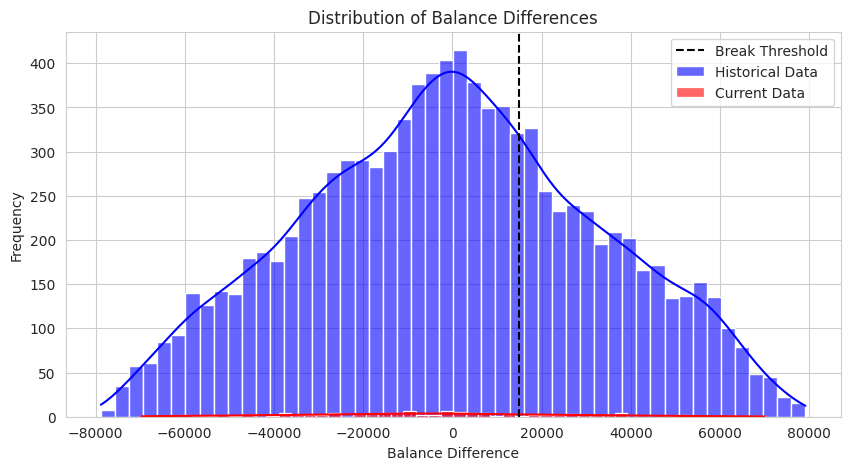

<ipython-input-3-ac8d3e1b6984>:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette="viridis")


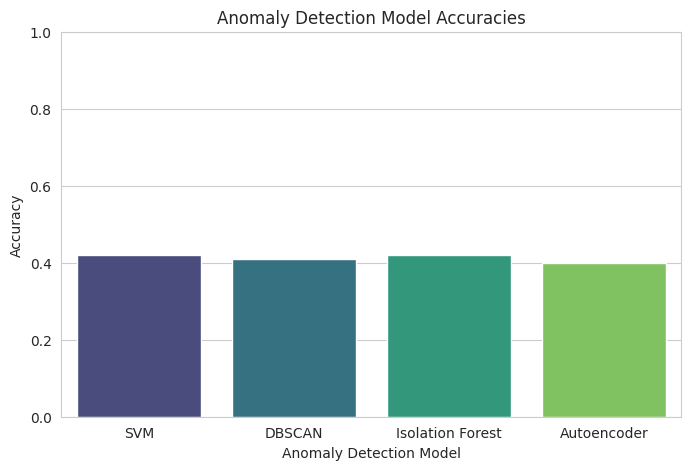

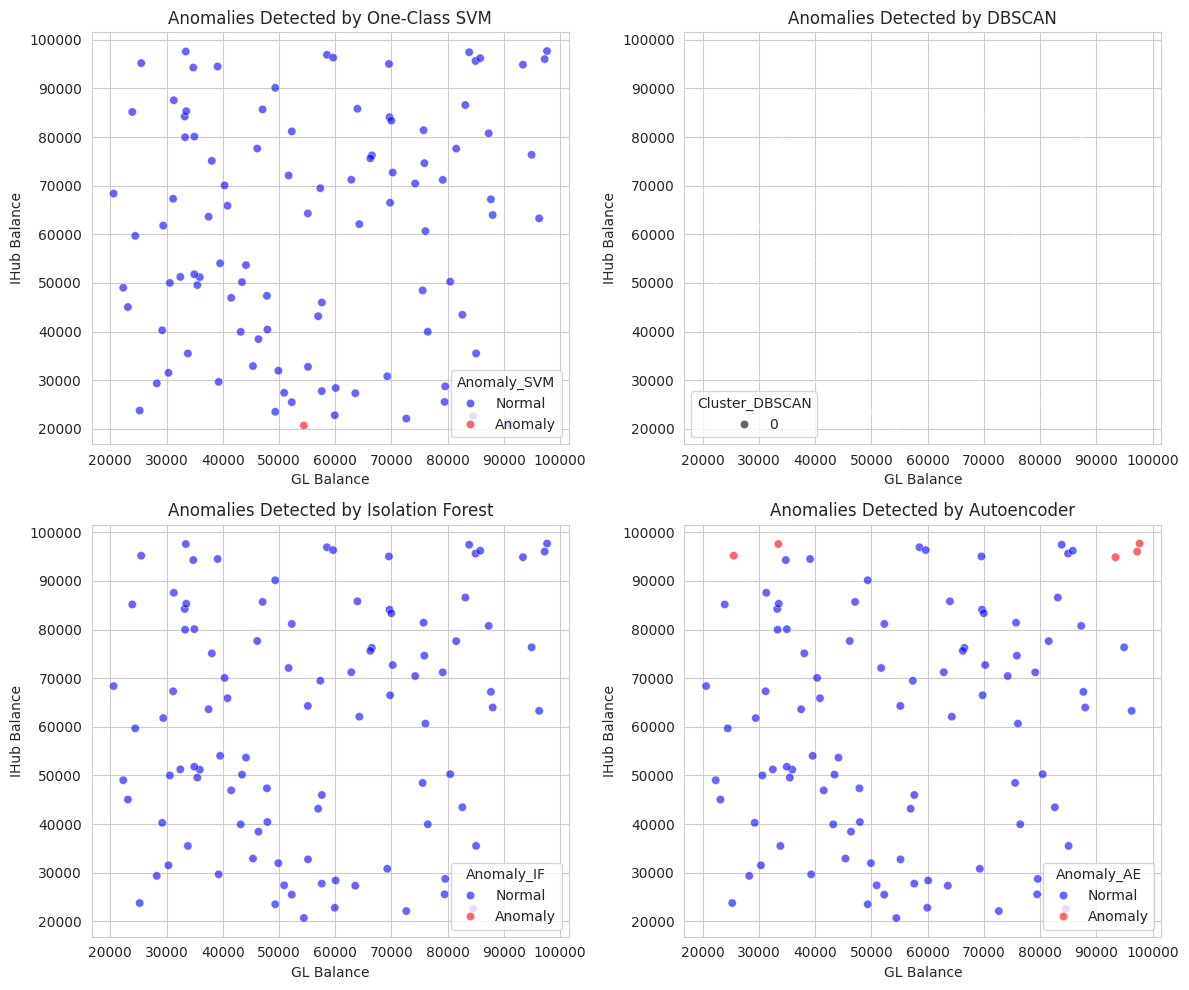

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

# Function to generate historical data
def generate_historical_data(n=10000):
    np.random.seed(42)
    data = {
        "Company": np.random.choice([1, 2, 3], n),
        "Account": np.random.choice([1619283, 1619205], n),
        "GL Balance": np.random.randint(20000, 100000, n),
        "IHub Balance": np.random.randint(20000, 100000, n),
    }
    df = pd.DataFrame(data)
    df["Balance Difference"] = df["GL Balance"] - df["IHub Balance"]
    df["Match Status"] = np.where(abs(df["Balance Difference"]) > 15000, "Break", "Match")
    df["Discrepancy Category"] = np.where(abs(df["Balance Difference"]) > 30000, "Significant Discrepancy", "Minor Discrepancy")
    return df

# Function to generate current data with anomalies
def generate_current_data(n=100):
    np.random.seed(99)
    data = {
        "Company": np.random.choice([1, 2, 3], n),
        "Account": np.random.choice([1619283, 1619205], n),
        "GL Balance": np.random.randint(20000, 100000, n),
        "IHub Balance": np.random.randint(20000, 100000, n),
    }
    df = pd.DataFrame(data)
    df["Balance Difference"] = df["GL Balance"] - df["IHub Balance"]
    df["Match Status"] = np.where(abs(df["Balance Difference"]) > 15000, "Break", "Match")
    df["Discrepancy Category"] = np.where(abs(df["Balance Difference"]) > 30000, "Significant Discrepancy", "Minor Discrepancy")
    return df

# Generate datasets
historical_df = generate_historical_data()
current_df = generate_current_data()

# Save datasets
historical_df.to_csv("historical_data.csv", index=False)
current_df.to_csv("current_data.csv", index=False)

# Feature selection
features = ["Company", "Account", "GL Balance", "IHub Balance", "Balance Difference"]
scaler = StandardScaler()
historical_scaled = scaler.fit_transform(historical_df[features])
current_scaled = scaler.transform(current_df[features])

# One-Class SVM for anomaly detection
oc_svm = OneClassSVM(nu=0.02, kernel='rbf', gamma='scale')
oc_svm.fit(historical_scaled)
current_df["Anomaly_SVM"] = oc_svm.predict(current_scaled)
current_df["Anomaly_SVM"] = current_df["Anomaly_SVM"].apply(lambda x: "Anomaly" if x == -1 else "Normal")

# DBSCAN for clustering
dbscan = DBSCAN(eps=np.mean(np.abs(historical_df["Balance Difference"])) * 0.5, min_samples=10)
current_df["Cluster_DBSCAN"] = dbscan.fit_predict(current_scaled)

# Isolation Forest for anomaly detection
iso_forest = IsolationForest(n_estimators=300, contamination=0.02, random_state=42)
iso_forest.fit(historical_scaled)
current_df["Anomaly_IF"] = iso_forest.predict(current_scaled)
current_df["Anomaly_IF"] = current_df["Anomaly_IF"].apply(lambda x: "Anomaly" if x == -1 else "Normal")

# Autoencoder for anomaly detection
model = Sequential([
    Dense(128, activation='relu', input_shape=(len(features),)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(len(features), activation='linear')
])

model.compile(optimizer='adam', loss='mse')
model.fit(historical_scaled, historical_scaled, epochs=300, batch_size=8, verbose=0)

reconstruction = model.predict(current_scaled)
reconstruction_error = np.mean(np.square(reconstruction - current_scaled), axis=1)
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)
current_df["Anomaly_AE"] = reconstruction_error > threshold
current_df["Anomaly_AE"] = current_df["Anomaly_AE"].apply(lambda x: "Anomaly" if x else "Normal")

# Evaluate accuracy (assuming 'Break' cases are anomalies)
y_true = (current_df["Match Status"] == "Break").astype(int)
y_pred_svm = (current_df["Anomaly_SVM"] == "Anomaly").astype(int)
y_pred_dbscan = (current_df["Cluster_DBSCAN"] == -1).astype(int)
y_pred_if = (current_df["Anomaly_IF"] == "Anomaly").astype(int)
y_pred_ae = (current_df["Anomaly_AE"] == "Anomaly").astype(int)

accuracy_svm = accuracy_score(y_true, y_pred_svm)
accuracy_dbscan = accuracy_score(y_true, y_pred_dbscan)
accuracy_if = accuracy_score(y_true, y_pred_if)
accuracy_ae = accuracy_score(y_true, y_pred_ae)

print("One-Class SVM Accuracy:", accuracy_svm)
print("DBSCAN Accuracy:", accuracy_dbscan)
print("Isolation Forest Accuracy:", accuracy_if)
print("Autoencoder Accuracy:", accuracy_ae)

# Display sample data
print("Historical Data Sample:")
print(historical_df.head())
print("\nCurrent Data Sample:")
print(current_df.head())

# Set plot style
sns.set_style("whitegrid")

# Plot 1: Distribution of Balance Differences
plt.figure(figsize=(10, 5))
sns.histplot(historical_df["Balance Difference"], bins=50, kde=True, color="blue", alpha=0.6, label="Historical Data")
sns.histplot(current_df["Balance Difference"], bins=50, kde=True, color="red", alpha=0.6, label="Current Data")
plt.axvline(15000, color='black', linestyle='--', label="Break Threshold")
plt.xlabel("Balance Difference")
plt.ylabel("Frequency")
plt.title("Distribution of Balance Differences")
plt.legend()
plt.show()

# Plot 2: Anomaly Detection Comparison
models = ["SVM", "DBSCAN", "Isolation Forest", "Autoencoder"]
accuracies = [accuracy_svm, accuracy_dbscan, accuracy_if, accuracy_ae]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracies, palette="viridis")
plt.ylim(0, 1)
plt.xlabel("Anomaly Detection Model")
plt.ylabel("Accuracy")
plt.title("Anomaly Detection Model Accuracies")
plt.show()

# Plot 3: Scatter plots for anomalies detected by each model
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

def plot_anomalies(ax, model_name, column):
    sns.scatterplot(data=current_df, x="GL Balance", y="IHub Balance", hue=column,
                    palette={"Normal": "blue", "Anomaly": "red"}, alpha=0.6, ax=ax)
    ax.set_title(f"Anomalies Detected by {model_name}")
    ax.set_xlabel("GL Balance")
    ax.set_ylabel("IHub Balance")

plot_anomalies(axes[0, 0], "One-Class SVM", "Anomaly_SVM")
plot_anomalies(axes[0, 1], "DBSCAN", "Cluster_DBSCAN")
plot_anomalies(axes[1, 0], "Isolation Forest", "Anomaly_IF")
plot_anomalies(axes[1, 1], "Autoencoder", "Anomaly_AE")

plt.tight_layout()
plt.show()

import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

# Function to generate historical data
def generate_historical_data(n=10000):
    np.random.seed(42)
    data = {
        "Company": np.random.choice([1, 2, 3], n),
        "Account": np.random.choice([1619283, 1619205], n),
        "GL Balance": np.random.randint(20000, 100000, n),
        "IHub Balance": np.random.randint(20000, 100000, n),
    }
    df = pd.DataFrame(data)
    df["Balance Difference"] = df["GL Balance"] - df["IHub Balance"]
    df["Match Status"] = np.where(abs(df["Balance Difference"]) > 15000, "Break", "Match")
    df["Discrepancy Category"] = np.where(abs(df["Balance Difference"]) > 30000, "Significant Discrepancy", "Minor Discrepancy")
    return df

# Function to generate current data with anomalies
def generate_current_data(n=100):
    np.random.seed(99)
    data = {
        "Company": np.random.choice([1, 2, 3], n),
        "Account": np.random.choice([1619283, 1619205], n),
        "GL Balance": np.random.randint(20000, 100000, n),
        "IHub Balance": np.random.randint(20000, 100000, n),
    }
    df = pd.DataFrame(data)
    df["Balance Difference"] = df["GL Balance"] - df["IHub Balance"]
    df["Match Status"] = np.where(abs(df["Balance Difference"]) > 15000, "Break", "Match")
    df["Discrepancy Category"] = np.where(abs(df["Balance Difference"]) > 30000, "Significant Discrepancy", "Minor Discrepancy")
    return df

# Generate datasets
historical_df = generate_historical_data()
current_df = generate_current_data()

# Feature selection and scaling
features = ["Company", "Account", "GL Balance", "IHub Balance", "Balance Difference"]
scaler = StandardScaler()
historical_scaled = scaler.fit_transform(historical_df[features])
current_scaled = scaler.transform(current_df[features])

# One-Class SVM for anomaly detection
oc_svm = OneClassSVM(nu=0.02, kernel='rbf', gamma='scale')
oc_svm.fit(historical_scaled)
current_df["Anomaly_SVM"] = oc_svm.predict(current_scaled)
current_df["Anomaly_SVM"] = current_df["Anomaly_SVM"].apply(lambda x: "Anomaly" if x == -1 else "Normal")

# DBSCAN for clustering
dbscan = DBSCAN(eps=np.mean(np.abs(historical_df["Balance Difference"])) * 0.5, min_samples=10)
current_df["Cluster_DBSCAN"] = dbscan.fit_predict(current_scaled)

# Isolation Forest for anomaly detection
iso_forest = IsolationForest(n_estimators=300, contamination=0.02, random_state=42)
iso_forest.fit(historical_scaled)
current_df["Anomaly_IF"] = iso_forest.predict(current_scaled)
current_df["Anomaly_IF"] = current_df["Anomaly_IF"].apply(lambda x: "Anomaly" if x == -1 else "Normal")

# Autoencoder for anomaly detection
model = Sequential([
    Dense(128, activation='relu', input_shape=(len(features),)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(len(features), activation='linear')
])

model.compile(optimizer='adam', loss='mse')
model.fit(historical_scaled, historical_scaled, epochs=300, batch_size=8, verbose=0)

reconstruction = model.predict(current_scaled)
reconstruction_error = np.mean(np.square(reconstruction - current_scaled), axis=1)
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)
current_df["Anomaly_AE"] = reconstruction_error > threshold
current_df["Anomaly_AE"] = current_df["Anomaly_AE"].apply(lambda x: "Anomaly" if x else "Normal")

# Identify anomalies detected by at least two models
current_df["Final_Anomaly"] = (current_df[["Anomaly_SVM", "Anomaly_IF", "Anomaly_AE"]]
                               .apply(lambda row: sum(row == "Anomaly"), axis=1) >= 2)

anomaly_df = current_df[current_df["Final_Anomaly"]]
anomaly_summary = anomaly_df[["Company", "Account", "GL Balance", "IHub Balance", "Balance Difference"]]

# Email setup
def send_email_anomalies(anomalies_df, recipient_email):
    sender_email = "your-email@gmail.com"  # Replace with your email
    sender_password = "your-app-password"  # Use an App Password

    subject = "Anomaly Detection Report"
    body = f"Dear Aneesha,\n\nPlease find below the detected anomalies in the financial data:\n\n{anomalies_df.to_string(index=False)}\n\nBest regards,\nPavan Sharma"

    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = recipient_email
    msg['Subject'] = subject
    msg.attach(MIMEText(body, 'plain'))

    try:
        server = smtplib.SMTP("smtp.gmail.com", 587)
        server.starttls()
        server.login(sender_email, sender_password)
        server.sendmail(sender_email, recipient_email, msg.as_string())
        server.quit()
        print("Anomaly report email sent successfully!")
    except Exception as e:
        print(f"Failed to send email: {e}")

# Send the email
send_email_anomalies(anomaly_summary, "aneeshabizzul@gmail.com")

NameError: name 'plt' is not defined